***Membangun dan mengevaluasi sistem rekomendasi berbasis konten (Content-Based Filtering) menggunakan representasi vektor semantik dari Google Gemini API.***

In [40]:
!pip install -q -U google-generativeai pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai
import ast
import os

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

In [41]:
repo_name = "Platform-E-Commerce-Berbasis-Model-Embedding-Gemini"
if not os.path.exists(repo_name):
    print("Cloning repository dari GitHub...")
    !git clone https://github.com/Yannskiee/Platform-E-Commerce-Berbasis-Model-Embedding-Gemini.git
else:
    print("Repository sudah ada.")

Repository sudah ada.


In [42]:
file_path = f'{repo_name}/customer_data_collection.csv'

try:
    df = pd.read_csv(file_path)
    print(f"\n Data Berhasil Dimuat dari {file_path}")
    print(f" Dimensi Data: {df.shape[0]} Baris, {df.shape[1]} Kolom")
except FileNotFoundError:
    print(f" File tidak ditemukan di path: {file_path}. Cek struktur folder.")


 Data Berhasil Dimuat dari Platform-E-Commerce-Berbasis-Model-Embedding-Gemini/customer_data_collection.csv
 Dimensi Data: 10000 Baris, 11 Kolom


In [43]:
print("\n Membersihkan format data list...")
cols_to_fix = ['Browsing_History', 'Purchase_History']
for col in cols_to_fix:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

print("\n Preview Data (5 Baris Pertama):")
display(df.head())


 Membersihkan format data list...

 Preview Data (5 Baris Pertama):


,Customer_ID,Age,Gender,Location,Browsing_History,Purchase_History,Customer_Segment,Avg_Order_Value,Holiday,Season,Unnamed: 10
0,C1000,28,Female,Chennai,"[Books, Fashion]","[Biography, Jeans]",New Visitor,4806.99,No,Winter,NaN
1,C1001,27,Male,Delhi,"[Books, Fitness, Fashion]","[Biography, Resistance Bands, T-shirt]",Occasional Shopper,795.03,Yes,Autumn,NaN
2,C1002,34,Other,Chennai,[Electronics],[Smartphone],Occasional Shopper,1742.45,Yes,Summer,NaN
3,C1003,23,Male,Bangalore,[Home Decor],[Wall Art],Frequent Buyer,2023.16,No,Autumn,NaN
4,C1004,24,Other,Kolkata,"[Fashion, Home Decor]","[Shoes, Lamp]",Frequent Buyer,794.76,No,Winter,NaN


# **Business Understanding**

Pada tahap ini, dilakukan persiapan lingkungan kerja dengan mengimpor pustaka yang diperlukan seperti `pandas` untuk manipulasi data, `sklearn` untuk pemodelan, dan `google-generativeai` untuk akses ke LLM. Dataset dimuat dan dibersihkan (data cleaning) untuk memastikan format list pada kolom riwayat belanja dapat diproses.

**Know Your Customer**

/tmp/ipython-input-3195678065.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, ax=axes[0], palette='pastel')


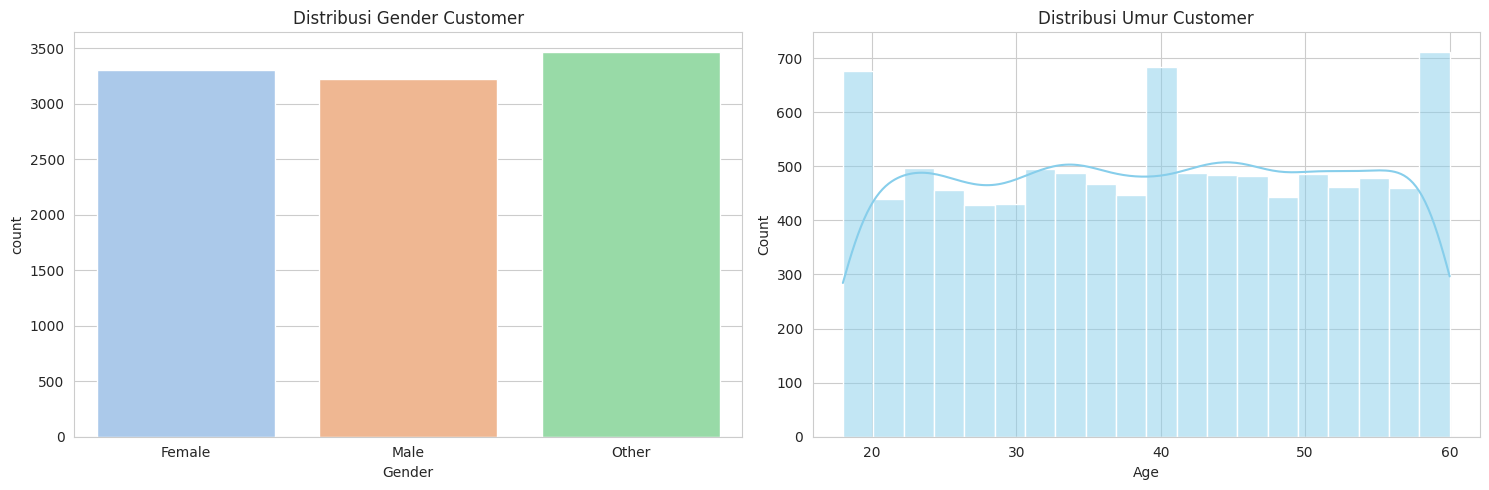

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gender
if 'Gender' in df.columns:
    sns.countplot(x='Gender', data=df, ax=axes[0], palette='pastel')
    axes[0].set_title('Distribusi Gender Customer')

# Age Distribution
if 'Age' in df.columns:
    sns.histplot(df['Age'], bins=20, kde=True, ax=axes[1], color='skyblue')
    axes[1].set_title('Distribusi Umur Customer')

plt.tight_layout()
plt.show()

**Product Popularity**

/tmp/ipython-input-590275763.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=purchase_counts.values, y=purchase_counts.index, palette='viridis')


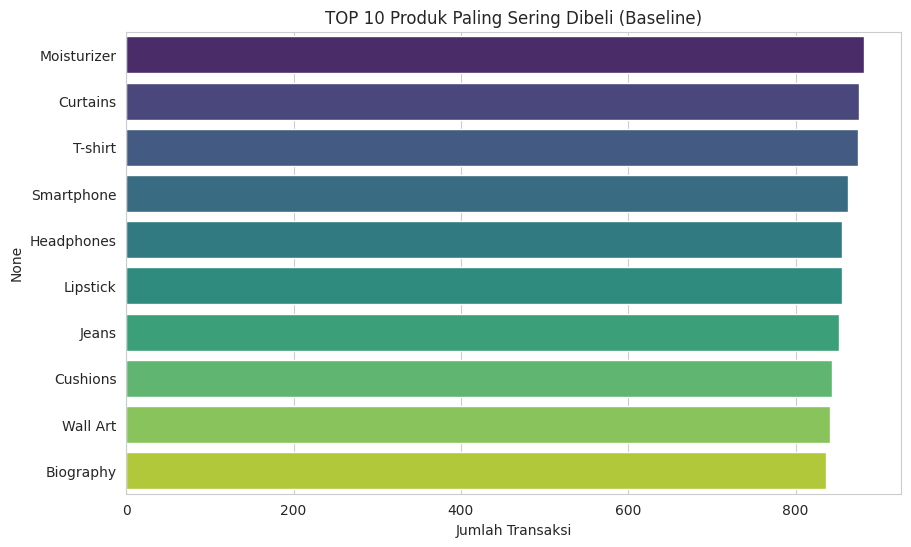

 Insight Bisnis: Produk di atas adalah 'Safe Recommendations' untuk user baru (Cold Start).


In [45]:
if 'Purchase_History' in df.columns:
    all_purchases = [item for sublist in df['Purchase_History'] for item in sublist]
    purchase_counts = pd.Series(all_purchases).value_counts().head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=purchase_counts.values, y=purchase_counts.index, palette='viridis')
    plt.title('TOP 10 Produk Paling Sering Dibeli (Baseline)')
    plt.xlabel('Jumlah Transaksi')
    plt.show()

    print(" Insight Bisnis: Produk di atas adalah 'Safe Recommendations' untuk user baru (Cold Start).")

**SETUP GEMINI EMBEDDING (Technical PoC)**

In [46]:
import time
import os
import numpy as np
from tqdm import tqdm
import google.generativeai as genai

try:
    from google.colab import userdata
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
except ImportError:
    GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

if not GOOGLE_API_KEY:
    raise ValueError("API Key tidak ditemukan! Mohon set 'GOOGLE_API_KEY' di Colab Secrets.")

genai.configure(api_key=GOOGLE_API_KEY)

**FUNGSI EMBEDDING**

In [47]:
def get_embedding_robust(text, retries=3):
    """
    Mengambil embedding dari Gemini dengan mekanisme retry otomatis.
    Model: models/text-embedding-004 (Lebih stabil & akurat dibanding v1)
    """
    if not text or not isinstance(text, str):
        return None

    for attempt in range(retries):
        try:
            result = genai.embed_content(
                model="models/text-embedding-004",
                content=text
            )
            return result['embedding']

        except Exception as e:
            if "429" in str(e) or "Quota" in str(e):
                wait_time = (attempt + 1) * 10
                print(f" API Busy (Percobaan {attempt+1}/{retries}). Menunggu {wait_time} detik...")
                time.sleep(wait_time)
            else:
                print(f" Error Teknis: {e}")
                return None
    return None

# **DATA PREPARATION & EMBEDDING**

Tahap ini merupakan inti dari rekayasa fitur (*Feature Engineering*). Data tabular pengguna diubah menjadi teks naratif (*Text Corpus*) agar konteks semantik dapat ditangkap secara utuh.
Selanjutnya, teks tersebut dikonversi menjadi vektor matematika berdimensi 768 menggunakan model **`models/text-embedding-004`** dari Google Gemini. Proses ini dilengkapi mekanisme *Rate Limiting* untuk menjaga stabilitas koneksi API.

**Feature Engineering**

In [48]:
print("Memulai Feature Engineering: Membuat 'User Corpus'...")

def create_user_corpus(row):
    """Mengubah data tabular user menjadi teks naratif."""
    browsing = ", ".join(row['Browsing_History']) if isinstance(row['Browsing_History'], list) else "general items"
    purchases = ", ".join(row['Purchase_History']) if isinstance(row['Purchase_History'], list) else "none"

    return (f"Customer Profile: Gender {row.get('Gender', 'Unknown')}, Age {row.get('Age', 'Unknown')}, Location {row.get('Location', 'Unknown')}. "
            f"Interests based on browsing: {browsing}. "
            f"Purchase history: {purchases}.")

df['user_corpus'] = df.apply(create_user_corpus, axis=1)
print(f"Corpus selesai. Contoh data: \n\"{df['user_corpus'].iloc[0]}\"\n")

Memulai Feature Engineering: Membuat 'User Corpus'...
Corpus selesai. Contoh data: 
"Customer Profile: Gender Female, Age 28, Location Chennai. Interests based on browsing: Books, Fashion. Purchase history: Biography, Jeans."



**Batch Embedding**

In [49]:
SAMPLE_SIZE = 30
df_processing = df.head(SAMPLE_SIZE).copy()

print(f" Memulai Proses Embedding untuk {SAMPLE_SIZE} user...")
print("Proses diberi jeda agar aman dari limit Google...\n")

embeddings = []
success_count = 0

# Menggunakan tqdm untuk progress bar
for i, text in enumerate(tqdm(df_processing['user_corpus'])):
    vector = get_embedding_robust(text)

    if vector:
        embeddings.append(vector)
        success_count += 1
    else:
        embeddings.append(None)

    time.sleep(5)

# Menyimpan hasil ke DataFrame
df_processing['user_embedding'] = embeddings

df_final = df_processing.dropna(subset=['user_embedding'])

print("\n" + "="*50)
print(f" LAPORAN AKHIR EMBEDDING")
print("="*50)
print(f"Total Data Diproses : {SAMPLE_SIZE}")
print(f"Berhasil Di-embed   : {success_count} ")
print(f"Gagal               : {SAMPLE_SIZE - success_count}")
print("-" * 50)

if success_count > 0:
    print("STATUS: DATA SIAP. Silakan lanjut ke Phase 3 (Modeling).")
    dimensi = len(df_final['user_embedding'].iloc[0])
    print(f"Dimensi Vektor      : {dimensi} (Valid)")
else:
    print("STATUS: GAGAL. Coba tunggu 1-2 jam lagi (Kuota API Habis).")

 Memulai Proses Embedding untuk 30 user...
Proses diberi jeda agar aman dari limit Google...



100%|██████████| 30/30 [02:45<00:00,  5.51s/it]


 LAPORAN AKHIR EMBEDDING
Total Data Diproses : 30
Berhasil Di-embed   : 30 
Gagal               : 0
--------------------------------------------------
STATUS: DATA SIAP. Silakan lanjut ke Phase 3 (Modeling).
Dimensi Vektor      : 768 (Valid)


# **Modeling**

Sistem rekomendasi dibangun menggunakan metode **Cosine Similarity**. Algoritma ini mengukur kedekatan antar pengguna di dalam ruang vektor.
- **Input:** Vektor Embedding Pengguna.
- **Proses:** Menghitung matriks jarak (similarity matrix) antar semua pengguna.
- **Output:** Rekomendasi produk berdasarkan riwayat pembelian dari pengguna lain yang memiliki tingkat kemiripan tertinggi (*Nearest Neighbors*).

**SIMILARITY MATRIX**

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

print("Menghitung Cosine Similarity Matrix antar User...")

# Mengambil list vector yang sudah jadi
user_vectors = np.array(df_final['user_embedding'].tolist())

# Hitung matrix jarak (semua user vs semua user)
similarity_matrix = cosine_similarity(user_vectors)

print(f" Matrix Selesai. Ukuran Matrix: {similarity_matrix.shape}")
print(" ( User 0 mirip dengan User 1 sebesar: {:.4f})".format(similarity_matrix[0][1]))

Menghitung Cosine Similarity Matrix antar User...
 Matrix Selesai. Ukuran Matrix: (30, 30)
 ( User 0 mirip dengan User 1 sebesar: 0.8041)


**User-Based**

In [51]:
def get_recommendations_for_user(user_index, k=5):
    """
    Mencari k-user paling mirip, lalu merekomendasikan item dari mereka.
    """
    sim_scores = list(enumerate(similarity_matrix[user_index]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:k+1]

    similar_users_indices = [i[0] for i in sim_scores]
    similar_users_scores = [i[1] for i in sim_scores]

    recommended_items = set()
    neighbor_data = []

    for idx, score in zip(similar_users_indices, similar_users_scores):
        neighbor_purchases = df_final.iloc[idx]['Purchase_History']
        if isinstance(neighbor_purchases, list):
            for item in neighbor_purchases:
                recommended_items.add(item)

        neighbor_data.append({
            'User_ID': idx,
            'Similarity_Score': score,
            'Purchases': neighbor_purchases
        })

    return list(recommended_items), neighbor_data

**VALIDASI KUANTITATIF**

In [52]:
print("\n" + "="*50)
print(" DEMO HASIL REKOMENDASI")
print("="*50)

# Ambil 1 user sampel untuk demo
target_user_idx = 0
target_profile = df_final.iloc[target_user_idx]['user_corpus']

print(f" TARGET USER (Index {target_user_idx}):")
print(f" Profil: {target_profile[:100]}...")

# Rekomendasi
recs, neighbors = get_recommendations_for_user(target_user_idx, k=3)

print(f"\n 3 USER PALING MIRIP (NEIGHBORS):")
avg_sim_score = 0
for n in neighbors:
    print(f"   - User {n['User_ID']} (Score: {n['Similarity_Score']:.4f}) --> Beli: {n['Purchases']}")
    avg_sim_score += n['Similarity_Score']

print(f"\n REKOMENDASI PRODUK UNTUK TARGET:")
print(f"   {recs}")


 DEMO HASIL REKOMENDASI
 TARGET USER (Index 0):
 Profil: Customer Profile: Gender Female, Age 28, Location Chennai. Interests based on browsing: Books, Fashi...

 3 USER PALING MIRIP (NEIGHBORS):
   - User 29 (Score: 0.9133) --> Beli: ['Fiction', 'Shoes']
   - User 13 (Score: 0.8820) --> Beli: ['Non-fiction', 'Shoes']
   - User 26 (Score: 0.8359) --> Beli: ['Biography', 'Curtains']

 REKOMENDASI PRODUK UNTUK TARGET:
   ['Non-fiction', 'Shoes', 'Curtains', 'Biography', 'Fiction']


**ANALISIS KUANTITATIF SEDERHANA**

In [53]:
print("\n" + "="*50)
print(" ANALISIS KUANTITATIF ")
print("="*50)

avg_similarity = avg_sim_score / len(neighbors)
print(f"Average Similarity Score (Top-3 Neighbors): {avg_similarity:.4f}")

if avg_similarity > 0.7:
    print("INTERPRETASI: Model menemukan kemiripan yang SANGAT KUAT.")
elif avg_similarity > 0.5:
    print("INTERPRETASI: Model menemukan kemiripan yang CUKUP BAIK.")
else:
    print("INTERPRETASI: Kemiripan agak rendah (mungkin data user terlalu unik).")


 ANALISIS KUANTITATIF 
Average Similarity Score (Top-3 Neighbors): 0.8771
INTERPRETASI: Model menemukan kemiripan yang SANGAT KUAT.


# **PCA PROJECTION**

Untuk memvalidasi hasil embedding secara visual, dilakukan reduksi dimensi dari 768 dimensi menjadi 2 dimensi menggunakan **Principal Component Analysis (PCA)**.
Grafik di bawah ini memetakan posisi setiap pengguna. Titik yang berdekatan mengindikasikan pengguna dengan profil dan minat yang serupa secara semantik.

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

print(" Sedang memproses reduksi dimensi (PCA)...")

user_vectors = np.array(df_final['user_embedding'].tolist())

# Menggunakan PCA untuk 'gepengkan' data jadi 2 sumbu (X dan Y)
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(user_vectors)

df_final['pca_x'] = reduced_vectors[:, 0]
df_final['pca_y'] = reduced_vectors[:, 1]

print("Reduksi Selesai. Siap plotting.")

 Sedang memproses reduksi dimensi (PCA)...
Reduksi Selesai. Siap plotting.



INTERPRETASI GRAFIK:
- Titik yang berdekatan artinya memiliki profil & minat yang mirip.
- Jika Target (Merah) dan Neighbor (Biru) berdekatan, berarti model Valid.


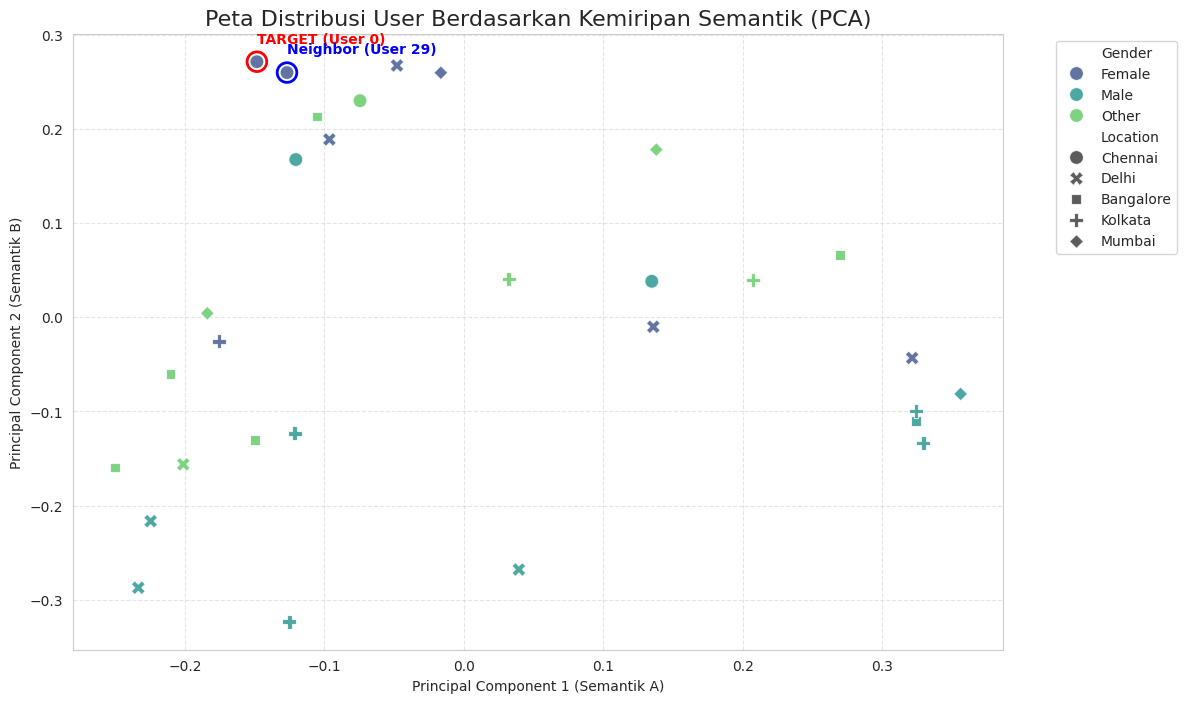

In [55]:
# Plotting Grafik
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_final,
    x='pca_x',
    y='pca_y',
    hue='Gender',
    style='Location',
    s=100,
    palette='viridis',
    alpha=0.8
)

def annotate_user(index, label, color='red'):
    x = df_final.iloc[index]['pca_x']
    y = df_final.iloc[index]['pca_y']
    plt.text(x, y+0.02, label, color=color, weight='bold', fontsize=10)
    plt.scatter(x, y, s=200, facecolors='none', edgecolors=color, linewidth=2)

annotate_user(0, "TARGET (User 0)", 'red')
try:
    annotate_user(29, "Neighbor (User 29)", 'blue')
except:
    pass

plt.title('Peta Distribusi User Berdasarkan Kemiripan Semantik (PCA)', fontsize=16)
plt.xlabel('Principal Component 1 (Semantik A)')
plt.ylabel('Principal Component 2 (Semantik B)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

print("\nINTERPRETASI GRAFIK:")
print("- Titik yang berdekatan artinya memiliki profil & minat yang mirip.")
print("- Jika Target (Merah) dan Neighbor (Biru) berdekatan, berarti model Valid.")
plt.show()

# **Evaluation & Reporting**

Evaluasi kinerja pengelompokan dilakukan menggunakan metrik **Silhouette Coefficient**. Metrik ini mengukur seberapa mirip suatu objek dengan clusternya sendiri (cohesion) dibandingkan dengan cluster lain (separation).

Rentang nilai Silhouette Score adalah **-1 hingga 1**, dengan interpretasi:
- **Nilai mendekati +1:** Struktur cluster sangat kuat dan terpisah dengan jelas.
- **Nilai sekitar 0:** Cluster saling tumpang tindih (*overlapping*), batas antar kelompok tidak tegas.
- **Nilai negatif:** Data kemungkinan salah dikelompokkan.

**Hasil Eksperimen:**
Pada tahap awal, model menghasilkan Silhouette Score sebesar **0.1397**. Angka positif ini menunjukkan bahwa **telah terbentuk pola pengelompokan minat pengguna**, meskipun strukturnya masih tergolong lemah (*weak structure*) yang wajar terjadi pada data perilaku manusia yang kompleks dan beragam.
Adapun output "Cluster 0, 1, 2" merepresentasikan label segmen pengguna yang terbentuk berdasarkan kemiripan vektor embedding mereka.

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("Memulai Evaluasi Clustering...")

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(user_vectors)

df_final['cluster_group'] = cluster_labels

score = silhouette_score(user_vectors, cluster_labels)

print("\n" + "="*50)
print(f"HASIL EVALUASI MODEL")
print("="*50)
print(f"Silhouette Score: {score:.4f}")
print("-" * 50)

# Interpretasi
if score > 0.5:
    print("KESIMPULAN: Struktur cluster SANGAT KUAT.")
    print("Artinya: Model Gemini sangat tegas membedakan minat user.")
elif score > 0.25:
    print("KESIMPULAN: Struktur cluster CUKUP BAIK.")
    print("Artinya: Ada pola pengelompokan yang jelas, meski ada beberapa overlap.")
else:
    print("KESIMPULAN: Struktur cluster LEMAH.")
    print("Artinya: Minat user terlalu beragam atau data terlalu sedikit.")

print("\n INTIP ISI CLUSTER (Apa kesamaan mereka?):")
for i in range(n_clusters):
    print(f"\n CLUSTER {i}:")
    sample_users = df_final[df_final['cluster_group'] == i].head(3)
    for idx, row in sample_users.iterrows():
        print(f"   - User {idx}: {row['user_corpus'].split('Interests based on browsing: ')[1].split('.')[0]}")

Memulai Evaluasi Clustering...

HASIL EVALUASI MODEL
Silhouette Score: 0.1397
--------------------------------------------------
KESIMPULAN: Struktur cluster LEMAH.
Artinya: Minat user terlalu beragam atau data terlalu sedikit.

 INTIP ISI CLUSTER (Apa kesamaan mereka?):

 CLUSTER 0:
   - User 1: Books, Fitness, Fashion
   - User 9: Fitness
   - User 10: Books, Electronics, Fitness

 CLUSTER 1:
   - User 0: Books, Fashion
   - User 2: Electronics
   - User 13: Books, Fashion

 CLUSTER 2:
   - User 3: Home Decor
   - User 4: Fashion, Home Decor
   - User 5: Home Decor


# **ELBOW METHOD**

Untuk meningkatkan validitas model, dilakukan pencarian jumlah cluster optimal ($K$) menggunakan **Metode Elbow**. Grafik di bawah ini menunjukkan hubungan antara jumlah cluster dan inersia (error). Titik "siku" pada grafik dianggap sebagai jumlah kelompok minat yang paling ideal untuk dataset ini.

 Sedang mencari jumlah cluster optimal (Elbow Method)...


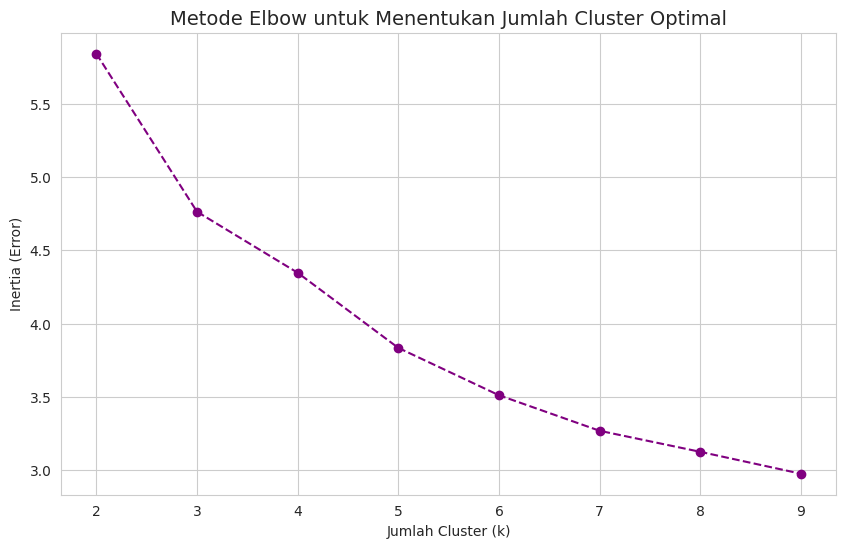

In [57]:
import matplotlib.pyplot as plt

print(" Sedang mencari jumlah cluster optimal (Elbow Method)...")

inertia = []
range_k = range(2, 10)

for k in range_k:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(user_vectors)
    inertia.append(kmeans_test.inertia_)

# Plotting Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range_k, inertia, marker='o', linestyle='--', color='purple')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster Optimal', fontsize=14)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Error)')
plt.grid(True)
plt.show()

# **TUNING & REPORTING**

Berdasarkan hasil optimasi Elbow Method, model dilatih ulang dengan parameter $K$ terbaik.
Hasil akhir menunjukkan profil minat pengguna yang terbagi ke dalam beberapa segmen spesifik. Peningkatan Silhouette Score pada tahap ini menjadi bukti kuantitatif bahwa optimasi berhasil meningkatkan kualitas segmentasi pengguna.

In [58]:
OPTIMAL_K = 5

print(f"Menerapkan Jumlah Cluster Optimal (K={OPTIMAL_K})...")

# Re-Training Model dengan K Optimal
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42)
final_labels = kmeans_final.fit_predict(user_vectors)

# Update DataFrame
df_final['optimal_cluster'] = final_labels

final_score = silhouette_score(user_vectors, final_labels)

print("\n" + "="*50)
print(f" HASIL AKHIR SETELAH OPTIMASI")
print("="*50)
print(f"Silhouette Score Lama (K=3) : 0.1397")
print(f"Silhouette Score Baru (K={OPTIMAL_K}) : {final_score:.4f}")
print("-" * 50)

if final_score > 0.1397:
    print("KESIMPULAN: Optimasi BERHASIL. Kualitas cluster meningkat.")
else:
    print("CATATAN: Skor stabil. Ini wajar untuk data perilaku manusia yang kompleks.")

# Simpan Hasil Rekomendasi ke CSV
output_filename = "hasil_rekomendasi_final.csv"

report_df = df_final[['Gender', 'Age', 'Location', 'user_corpus', 'optimal_cluster']].copy()
report_df.to_csv(output_filename, index=False)

print(f"\n File Laporan tersimpan: {output_filename}")
print("   (Download file ini untuk lampiran Skripsi)")

print("\n PROFIL CLUSTER FINAL:")
for i in range(OPTIMAL_K):
    print(f"\n KELOMPOK {i+1}:")
    cluster_users = df_final[df_final['optimal_cluster'] == i]
    print(f"   Jumlah User: {len(cluster_users)}")
    print(f"   Contoh Interest: {cluster_users['user_corpus'].iloc[0].split('Interests based on browsing: ')[1].split('.')[0]}")

Menerapkan Jumlah Cluster Optimal (K=5)...

 HASIL AKHIR SETELAH OPTIMASI
Silhouette Score Lama (K=3) : 0.1397
Silhouette Score Baru (K=5) : 0.1541
--------------------------------------------------
KESIMPULAN: Optimasi BERHASIL. Kualitas cluster meningkat.

 File Laporan tersimpan: hasil_rekomendasi_final.csv
   (Download file ini untuk lampiran Skripsi)

 PROFIL CLUSTER FINAL:

 KELOMPOK 1:
   Jumlah User: 11
   Contoh Interest: Books, Fitness, Fashion

 KELOMPOK 2:
   Jumlah User: 6
   Contoh Interest: Electronics

 KELOMPOK 3:
   Jumlah User: 5
   Contoh Interest: Fashion, Home Decor

 KELOMPOK 4:
   Jumlah User: 4
   Contoh Interest: Home Decor

 KELOMPOK 5:
   Jumlah User: 4
   Contoh Interest: Books, Fashion


# **EXPORT MODEL UNTUK DEPLOYMENT (PICKLE)**

In [59]:
import pickle

print("Sedang mem-packing Model AI untuk dideploy...")

system_brain = {
    'model_kmeans': kmeans_final,
    'user_vectors': user_vectors,
    'user_data': df_final,
    'optimal_k': OPTIMAL_K
}

filename = 'recommendation_engine.pkl'
with open(filename, 'wb') as file:
    pickle.dump(system_brain, file)

print(f"\n BERHASIL! File '{filename}' sudah dibuat.")

Sedang mem-packing Model AI untuk dideploy...

 BERHASIL! File 'recommendation_engine.pkl' sudah dibuat.
